In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import torch
from torch.utils.data import DataLoader, random_split
from leap.datasets.physics_dataset import PhysicsDatasetTuple
from leap.tools.utils import load_yaml
import torchvision.transforms as transforms
from leap.modules.components.beta import BetaVAE_Physics
from leap.modules.components.graph import GNNModel
from leap.modules.physics_vae import PhysicsVAE
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cfg = load_yaml('../leap/configs/ball_5_s1.yaml')

trans_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
class Namespace(object):
    def __init__(self, **kwds):
        self.__dict__.update(kwds)
    def __repr__(self):
        items = list(self.__dict__.items())
        temp = []
        for name, value in items:
            if not name.startswith('_'):
                temp.append('%s=%r' % (name, value))
        temp.sort()
        return '%s(%s)' % (self.__class__.__name__, ', '.join(temp))


In [20]:
# Genenrate args
phase = 'raw'
namespace = Namespace()
for k in cfg:
    setattr(namespace, k, cfg[k])

trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.9920, 0.9887, 0.9860), (0.0692, 0.0670, 0.0949))
])
data = PhysicsDatasetTuple(namespace, phase=phase, trans_to_tensor=trans_to_tensor)
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=4, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [36]:
data.__getitem__(0)['yt_'].shape

torch.Size([1, 10])

In [11]:
for batch in train_loader:
    break

> /home/weiran/project/ltcl/ltcl/datasets/physics_dataset.py(631)seq_to_pairs()
    630         pdb.set_trace()
--> 631         x = x.unfold(dimension = 0, size = self.L+1, step = 1)
    632         x = torch.swapaxes(x, 1, 2)

ipdb> q


BdbQuit: 

In [216]:
model = PhysicsVAE(3,5,z_dim=64)

In [751]:
model = model.load_from_checkpoint("/data/datasets/logs/cmu_wyao/try_ball_1_g10_gat/lightning_logs/version_22/checkpoints/epoch=0-step=2330.ckpt",
                                   nc = 3, n_obj=5,z_dim=8, lag=1,hidden_dim=512,num_layers=3)

In [752]:
x_recon, mu, logvar, z = model(batch)

In [755]:
adj = torch.nn.functional.gumbel_softmax(model.logits, hard=True)[:,:,0].fill_diagonal_(1)
print(adj)

tensor([[1., 1., 0., 0., 0.],
        [0., 1., 1., 0., 1.],
        [0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0.],
        [1., 1., 1., 1., 1.]], grad_fn=<AsStridedBackward>)


/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Learned noise prior')

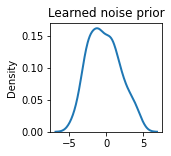

In [756]:
import seaborn as sns
fig = plt.figure(figsize=(2,2))
eps = model.sample(x_recon.cpu())
eps = eps.detach().cpu().numpy()
component_idx = 16
sns.distplot(eps[:,component_idx], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2});
plt.title("Learned noise prior")

In [757]:
def denormalize(x):
    x = x * torch.tensor([0.0692, 0.0670, 0.0949]).reshape(3,1,1) + torch.tensor([0.9920, 0.9887, 0.9860]).reshape(3,1,1)
    return x

In [758]:
x, kps_gt, graph_gt, actions = batch
# Concatenate x to the shape of x_recon triplets
triples = []
for i in range(4 - 2):
    # pair consecutive frames (n, 2c, w, h)
    triple = torch.stack((x[:, i], x[:, i+1], x[:, i+2]), 1)
    triples.append(triple)
triples = torch.stack(triples, dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

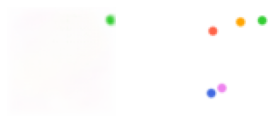

In [764]:
sample_idx = 32
ts = 2
fig, axs = plt.subplots(1,2,figsize=(5,2))
axs[0].imshow(denormalize(x_recon[sample_idx][0][ts]).permute(1,2,0).detach().cpu().numpy())
axs[1].imshow(denormalize(triples[sample_idx][0][ts]).permute(1,2,0).detach().cpu().numpy())
axs[0].axis('off')
axs[1].axis('off')

In [463]:
x_recon[sample_idx][0][0][1]

tensor([[ 0.1292,  0.1611,  0.1441,  ...,  0.1599,  0.2034,  0.1890],
        [ 0.0772,  0.0726, -0.1533,  ...,  0.1489,  0.1657,  0.1611],
        [-0.1856, -0.5097, -0.9532,  ...,  0.1818,  0.1692,  0.1740],
        ...,
        [ 0.0562,  0.0611,  0.0619,  ...,  0.1495,  0.1532,  0.1818],
        [ 0.0827,  0.1226,  0.1175,  ...,  0.1625,  0.1807,  0.1827],
        [ 0.1022,  0.1325,  0.1317,  ...,  0.1608,  0.1699,  0.1658]],
       grad_fn=<SelectBackward>)

In [464]:
triples[sample_idx][0][0][2]

tensor([[ 0.1475,  0.1475,  0.1475,  ...,  0.1475,  0.1475,  0.1475],
        [ 0.1475,  0.1475,  0.1475,  ...,  0.1475,  0.1475,  0.1475],
        [ 0.1475,  0.1062, -0.1417,  ...,  0.1475,  0.1475,  0.1475],
        ...,
        [ 0.1475,  0.1475,  0.1475,  ...,  0.1475,  0.1475,  0.1475],
        [ 0.1475,  0.1475,  0.1475,  ...,  0.1475,  0.1475,  0.1475],
        [ 0.1475,  0.1475,  0.1475,  ...,  0.1475,  0.1475,  0.1475]])

In [184]:
img = triples[sample_idx][0][0].permute(1,2,0).detach().cpu().numpy()

In [6]:
imgs, kps_gt, graph_gt, actions = datasets.__getitem__(1)

In [7]:
frames = imgs.unsqueeze(0).expand(16, -1, -1, -1, -1)

In [31]:
adj = torch.tensor([[0,1,0,1.],
                    [1,0,1,0],
                    [1,1,1,1],
                    [0,0,1,1]], requires_grad=True)

In [32]:
from torch_geometric.utils.sparse import dense_to_sparse

In [35]:
dense_to_sparse(adj)[1]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<IndexBackward>)

In [27]:
adj.nonzero(as_tuple=True)

(tensor([0, 1]), tensor([1, 0]))

In [21]:
batch_size = 8

In [40]:
gnn = GNNModel(32,32,32)
logits = torch.randn(5,5,2)
logits[:,:,1] = logits[:,:,1]-5
logits.requires_grad = True

In [331]:
adj = torch.nn.functional.gumbel_softmax(model.logits, hard=True)[:,:,0].fill_diagonal_(1)
# adj = adj.unsqueeze(0).repeat(batch_size, 1, 1)

In [332]:
adj

tensor([[1., 0., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [0., 1., 1., 1., 1.]], grad_fn=<AsStridedBackward>)

In [117]:
x = torch.randn(batch_size, 5, 32)

In [118]:
loss  = gnn(x, adj).sum()

In [119]:
grads = loss.backward()

In [120]:
logits.grad[1,1]

tensor([0., 0.])

In [25]:
adj.shape

torch.Size([5, 5])

In [27]:
mask = ~torch.eye(adj.shape[0],dtype=bool)

In [29]:
torch.masked_select(adj, mask)

tensor([0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 0.], grad_fn=<MaskedSelectBackward>)